<a href="https://colab.research.google.com/github/lmbd92/st1800-st1801-trabajo3-2261/blob/main/Trabajo3Lina_Jose.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Integrantes: Lina Beltrán (lbeltra1@eafit.edu.co), Jose Muñoz (jjmunozm@eafit.edu.co)

Materia: Alm. & Recu. de información.

Trabajo 3

Universidad EAFIT - Maestria ciencia en datos y analítica

Trabajo 2 Unidad 2 recuperación de texto

Data: https://github.com/lmbd92/st1800-st1801-trabajo3-2261/blob/main/Trabajo3/twitter.txt

# Abrir archivos desde GitHub

In [40]:
# OJO!!!! Ejecutar este bloque una sola vez (Por cada sesión iniciada)

#!git clone -l -s https://github.com/lmbd92/st1800-st1801-trabajo3-2261.git cloned-repo
#%cd cloned-repo
#!ls

In [41]:
# Delete repo local colab (Usar solo en caso de requerir actualizar el repo desde Github Nuevamente)

#!rm -r /content/cloned-repo

**Nota:** Para guardar el notebook directamente en Github, dirigirse a File→Save a copy in GitHub

# Preparación de ambiente de trabajo (Dependencias/librerias)

In [42]:
# Transmisión eficiente de archivos muy grandes desde/hacia almacenamientos como S3, GCS, Azure Blob Storage, HDFS, WebHDFS
!pip install smart-open

# Modelado y procesamiento NLP
!pip install --upgrade gensim
!pip install nltk

# Interpretar el tema en un modelo de temas que se ha ajustado a un corpus
!pip install pyLDAvis

In [43]:
import pandas as pd
import numpy as np
import nltk
# Soporte para expresiones regulares (RE).
import re

In [44]:
# nltk: tokenizador y stopwords

from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('words')
nltk.download('wordnet')
nltk.download('omw-1.4')
stop_words_nltk = set(stopwords.words('english'))
print(len(stopwords.words('english')))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
179


In [45]:
#Lematizar, Stem
from nltk.stem import WordNetLemmatizer
from nltk.stem import LancasterStemmer
#
lancaster = LancasterStemmer()
wordnet_lemmatizer = WordNetLemmatizer()

In [46]:
#imprimir listas grandes
import pprint
from pprint import pprint

# Carga de Data Raw y EDA básico



In [47]:
# Carga de los datos

path_in = '/content/cloned-repo/Trabajo3/'
path_out = '/content/cloned-repo/Trabajo3/out/'
file_name = 'twitterClimateData.csv'

df = pd.read_csv(f'{path_in}{file_name}')
df.head()

,Unnamed: 0,id,author_id,text,retweets,permalink,date,formatted_date,favorites,mentions,...,location,text_clean,tb_sentiment_polarity,tb_sentiment_subjectivity,textBlob_sentiment,vader_compound,vader_pos,vader_neg,vader_neu,V_Sentiment
0,0,1.211810e+18,7.590000e+17,"2020 is the year we #votethemout, the year we ...",15,https://twitter.com/Sphiamia/status/1211807074...,2019-12-31 00:31:35+00:00,Tue Dec 31 00:31:35 +0000 2019,46,NaN,...,"California, USA",2020 is the year we votethemout the year we cl...,-0.100000,0.462500,negative,-0.5682,0.000,0.131,0.869,Negative
1,1,1.210670e+18,2.219547e+07,Winter has not stopped this group of dedicated...,9,https://twitter.com/StephDujarric/status/12106...,2019-12-27 20:56:21+00:00,Fri Dec 27 20:56:21 +0000 2019,35,NaN,...,"California, USA",Winter has not stopped this group of dedicated...,0.000000,0.000000,positive,0.5670,0.215,0.000,0.785,Positive
2,2,1.210590e+18,1.070000e+18,WEEK 55 of #ClimateStrike at the @UN. Next wee...,545,https://twitter.com/AlexandriaV2005/status/121...,2019-12-27 15:50:22+00:00,Fri Dec 27 15:50:22 +0000 2019,3283,@UN @Fridays4future,...,"California, USA",WEEK 55 of ClimateStrike at the UN Next week F...,0.166667,0.333333,positive,-0.8567,0.023,0.180,0.797,Negative
3,3,1.210260e+18,1.339821e+09,"A year of resistance, as youth protests shape...",1,https://twitter.com/EnergyHouseVA/status/12102...,2019-12-26 17:53:26+00:00,Thu Dec 26 17:53:26 +0000 2019,2,NaN,...,"California, USA",A year of resistance as youth protests shaped...,0.183333,0.600000,positive,0.7739,0.203,0.051,0.746,Positive
4,4,1.209640e+18,1.339821e+09,HAPPY HOLIDAYS #greta #gretathunberg #climate...,1,https://twitter.com/EnergyHouseVA/status/12096...,2019-12-25 00:56:37+00:00,Wed Dec 25 00:56:37 +0000 2019,4,NaN,...,"California, USA",HAPPY HOLIDAYS greta gretathunberg climatecha...,0.650000,0.800000,positive,0.9413,0.451,0.000,0.549,Positive


In [48]:
df.shape

(72405, 24)

In [49]:
df.count()

Unnamed: 0                   72405
id                           72405
author_id                    72405
text                         72405
retweets                     72405
permalink                    72405
date                         72405
formatted_date               72405
favorites                    72405
mentions                     27554
hashtags                     72402
geo                              0
urls                         33349
search_hashtags              72405
location                     72405
text_clean                   72405
tb_sentiment_polarity        72405
tb_sentiment_subjectivity    72405
textBlob_sentiment           72405
vader_compound               72405
vader_pos                    72405
vader_neg                    72405
vader_neu                    72405
V_Sentiment                  72405
dtype: int64

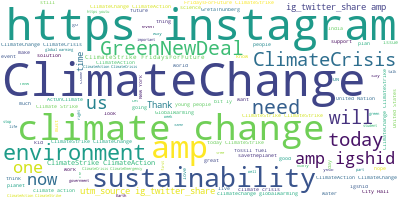

In [50]:
# Importar wordcloud Libreria
from wordcloud import WordCloud
# Unir palabras y caracteres Raw
long_string = ','.join(list(df['text'].values))
# Crear objeto de nube de palabras
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generar nube de palabras
wordcloud.generate(long_string)
# Visualización
wordcloud.to_image()

# Preparación de data, Nubes de tokens y Frecuencia

Definimos funcion para optimizar incluyendo stem y Lematización

In [51]:
def textprep(line):
    tokens = nltk.word_tokenize(str(line))
    tokens = [w.lower() for w in tokens if len(w)>1]
    tokens = [re.sub(r'[^A-Za-z0-9]+','',w) for w in tokens]
    tokens = [w for w in tokens if w not in stop_words_nltk] 
    tokens= [wordnet_lemmatizer.lemmatize(w) for w in tokens]
    tokens= [lancaster.stem(w) for w in tokens]
    return tokens

In [52]:
#Filtramos solo la columna de interés
text_df = df[['text']]
text_df.head()

,text
0,"2020 is the year we #votethemout, the year we ..."
1,Winter has not stopped this group of dedicated...
2,WEEK 55 of #ClimateStrike at the @UN. Next wee...
3,"A year of resistance, as youth protests shape..."
4,HAPPY HOLIDAYS #greta #gretathunberg #climate...


In [53]:
# creación de columna con tokenización de la columna de interés especifica
text_df['tokens_twitter'] = text_df.apply(lambda row: textprep(row['text']), axis=1)
text_df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,text,tokens_twitter
0,"2020 is the year we #votethemout, the year we ...","[2020, year, votethemout, year, climatestrik, ..."
1,Winter has not stopped this group of dedicated...,"[wint, stop, group, ded, clim, act, exampl, fo..."
2,WEEK 55 of #ClimateStrike at the @UN. Next wee...,"[week, 55, climatestrik, un, next, week, frida..."
3,"A year of resistance, as youth protests shape...","[year, resist, you, protest, shap, clim, chang..."
4,HAPPY HOLIDAYS #greta #gretathunberg #climate...,"[happy, holiday, gret, gretathunberg, climatec..."


Representación Frecuencia Visual del BoW optimizado

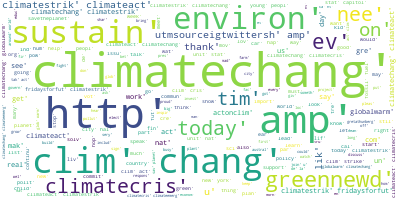

In [54]:
#Convertir Tokens en Lista y Str
tokens_twitter_list=text_df['tokens_twitter'].to_list()
tokens_twitter_str=" ".join([str(item) for item in tokens_twitter_list ])
# Crear nube de palabras
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generar nube de palabras
wordcloud.generate(tokens_twitter_str)
# Visualización
wordcloud.to_image()

# Características y representación

Construir el BoW (diccionario) de términos

In [55]:
len(text_df['tokens_twitter'])

72405

In [72]:
# Creación del BoW - en gensim es Dictionary
from gensim.corpora import Dictionary
dictionary = Dictionary(text_df.tokens_twitter)
print(dictionary)

Dictionary(77295 unique tokens: ['2020', '33', 'climatestrik', 'don', 'els']...)


In [57]:
# Bag-of-words representacion de documentos.
corpus = [dictionary.doc2bow(line) for line in text_df.tokens_twitter]

In [58]:
for i in corpus[:10]:
    print(i)

[(0, 2), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 4)]
[(2, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1)]
[(0, 1), (2, 1), (6, 1), (15, 1), (16, 1), (17, 1), (24, 2), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 2)]
[(0, 1), (2, 1), (15, 1), (16, 1), (17, 2), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 2)]
[(2, 1), (17, 1), (49, 1), (51, 1), (52, 1), (54, 1), (55, 1), (56, 1), (57, 2), (58, 1), (59, 1), (63, 1), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1), (74, 1), (75, 1), (76, 1), (77, 1)]
[(2, 1), (17, 2), (36, 1), (50, 1), (52, 1), (54, 1), (56, 1), (57, 1), (78, 1), (79,

Construir matriz de documentos vs términos

In [59]:
# libreria para paralelizar
import multiprocessing as mp
import time

pool = mp.Pool(mp.cpu_count())
doc_term_matrix = pool.map(dictionary.doc2bow, [sentence for sentence in text_df.tokens_twitter])
pool.close()

In [60]:
for i in doc_term_matrix[:5]:
    print(i)

[(0, 2), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 4)]
[(2, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1)]
[(0, 1), (2, 1), (6, 1), (15, 1), (16, 1), (17, 1), (24, 2), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 2)]
[(0, 1), (2, 1), (15, 1), (16, 1), (17, 2), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 2)]
[(2, 1), (17, 1), (49, 1), (51, 1), (52, 1), (54, 1), (55, 1), (56, 1), (57, 2), (58, 1), (59, 1), (63, 1), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1), (74, 1), (75, 1), (76, 1), (77, 1)]


# Modelo no supervisado LDA

Modelo LDA

In [61]:
#from gensim.models.ldamulticore import LdaMulticore

#t0 = time.time()
#lda_model = LdaMulticore(doc_term_matrix, num_topics=20, id2word = dictionary, passes=10, workers=10)
#print(time.time()-t0)

In [64]:
# Build LDA model Otro modelo lda, tiene otro nombr para no confundirse
from gensim.models.ldamulticore import LdaMulticore
from gensim import corpora, models, similarities

lda_model2 = models.LdaModel(corpus=corpus,
                                       id2word=dictionary,
                                       num_topics=10, passes=5, alpha='auto')


91.8602774143219


In [74]:
print(lda_model2)

LdaModel(num_terms=77295, num_topics=10, decay=0.5, chunksize=2000)


In [65]:
def assigntopic(doc):
    vector = lda_model2[dictionary.doc2bow(doc)] 
    # opción 1: todos los tópicos ordenados de mayor a menor, podria ser topN tambien asi: return vector[:5] n=5
    #vector = sorted(vector, key=lambda item: -item[1])
    # opción 2: asignar el tópico mayor a cada documento
    vector = max(vector,key=lambda item: item[1])
    return vector

In [ ]:
text_df['topics'] = text_df.apply(lambda row: assigntopic(row['tokens_twitter']), axis=1)
text_df.head(10)

In [71]:
text_df.head(10)

,text,tokens_twitter,topics
0,"2020 is the year we #votethemout, the year we ...","[2020, year, votethemout, year, climatestrik, ...","(3, 0.6163625)"
1,Winter has not stopped this group of dedicated...,"[wint, stop, group, ded, clim, act, exampl, fo...","(3, 0.63810366)"
2,WEEK 55 of #ClimateStrike at the @UN. Next wee...,"[week, 55, climatestrik, un, next, week, frida...","(3, 0.79957044)"
3,"A year of resistance, as youth protests shape...","[year, resist, you, protest, shap, clim, chang...","(3, 0.5190569)"
4,HAPPY HOLIDAYS #greta #gretathunberg #climate...,"[happy, holiday, gret, gretathunberg, climatec...","(3, 0.40614575)"
5,10 Questions to Ask Politicians About Climate...,"[10, quest, ask, polit, clim, chang, http, www...","(3, 0.7711042)"
6,#climatestrike #FridaysForFuture #portraits #u...,"[climatestrik, fridaysforfut, portrait, unique...","(0, 0.4583422)"
7,#ClimateChangeIsReal #ClimateStrike #ClimateAc...,"[climatechangeisr, climatestrik, climateaction...","(3, 0.44943976)"
8,My oldest daughter finding inspiration and enc...,"[oldest, daught, find, inspir, enco, fut, read...","(3, 0.5370464)"
9,Our toddler #POTUS whined this week about #Tim...,"[toddl, pot, whin, week, tim, magazin, pick, g...","(4, 0.4404266)"


In [75]:
# Imprimir Keyword en los topics
pprint(lda_model2.print_topics())
doc_lda = lda_model2[corpus]


[(0,
  '0.141*"climatestrik" + 0.042*"fridaysforfut" + 0.035*"today" + '
  '0.034*"gretathunberg" + 0.021*"stud" + 0.019*"clim" + 0.018*"dc" + '
  '0.016*"capitol" + 0.016*"join" + 0.015*"stat"'),
 (1,
  '0.038*"climatechangeisr" + 0.024*"pleas" + 0.016*"check" + 0.012*"design" + '
  '0.011*"hey" + 0.010*"gard" + 0.010*"excel" + 0.009*"collab" + '
  '0.009*"landscapearchitect" + 0.009*"plasticpollut"'),
 (2,
  '0.047*"le" + 0.016*"fre" + 0.016*"pres" + 0.014*"resy" + 0.014*"whit" + '
  '0.012*"heat" + 0.011*"link" + 0.010*"fal" + 0.010*"district" + '
  '0.010*"award"'),
 (3,
  '0.038*"climatechang" + 0.025*"sustain" + 0.025*"http" + 0.018*"amp" + '
  '0.015*"clim" + 0.014*"environ" + 0.013*"climatecris" + 0.012*"climateact" + '
  '0.010*"chang" + 0.009*"greennewd"'),
 (4,
  '0.040*"sydney" + 0.018*"produc" + 0.017*"excit" + 0.014*"memb" + '
  '0.012*"europ" + 0.012*"consum" + 0.012*"understand" + 0.011*"disc" + '
  '0.010*"cov" + 0.010*"strong"'),
 (5,
  '0.031*"city" + 0.021*"er" + 0.

In [77]:
len(doc_lda)
len(lda_model2.print_topics())

10

Analizando Resultados del LDA 

In [78]:
#from pyLDAvis 
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import pickle 


In [80]:
# Visualize the topics
pyLDAvis.enable_notebook()

#LDAvis_data_filepath = os.path.join(')
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = gensimvis.prepare(lda_model2, corpus, dictionary)
    with open("/content/cloned-repo/Trabajo3/out", 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
# load the pre-prepared pyLDAvis data from disk
with open("/content/cloned-repo/Trabajo3/out", 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, '/content/cloned-repo/Trabajo3/out.html')
LDAvis_prepared

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.406728 -0.170362       1        1  57.888805
0     -0.249690  0.286321       2        1  11.438485
8      0.055788 -0.163216       3        1   4.874404
5      0.072777 -0.012019       4        1   4.343256
1      0.049245 -0.152521       5        1   4.275493
6      0.093690  0.049732       6        1   3.862810
7      0.100216  0.053198       7        1   3.662569
9      0.098620  0.027829       8        1   3.628449
4      0.103595  0.012870       9        1   3.257648
2      0.082488  0.068169      10        1   2.768082, topic_info=               Term          Freq         Total Category  logprob  loglift
126                  14518.000000  14518.000000  Default  30.0000  30.0000
2      climatestrik  18597.000000  18597.000000  Default  29.0000  29.0000
52     climatechang  25372.000000  25372.000000  Default  28.0000  28.0000
54    fridaysforfut   5471.000000   5471.000000  Default  27.0000  27.0000
223           today   5677.000000   5677.000000  Default  26.0000  26.0000
...             ...           ...           ...      ...      ...      ...
452            main    184.843988    185.791169  Topic10  -5.1499   3.5819
2131        network    183.133385    184.080620  Topic10  -5.1592   3.5819
443            miss    306.140837    466.787126  Topic10  -4.6454   3.1652
846            cont    189.174710    204.841924  Topic10  -5.1268   3.5074
72             hous    208.491777   1661.730902  Topic10  -5.0295   1.5113

[401 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
126       7  0.999955        
1876      4  0.997201     abl
894       6  0.994097  absolv
1908      8  0.995223  achiev
16        1  0.800402     act
...     ...       ...     ...
2150      5  0.994042     wow
639       7  0.996017    writ
66        2  0.999442     you
210       2  0.999708   young
3106     10  0.993943    zero

[462 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 9, 6, 2, 7, 8, 10, 5, 3])

# Clasificación y análisis de sentimientos

# REFERENCIAS 

https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0